In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import csv

In [2]:
row_start = 14

In [3]:
# metadata = dict()
filename = "1B - Adrian - new.CSV"
with open(filename, newline='') as csvfile:
    reader = csv.reader(csvfile)

In [4]:
data = pd.read_csv(filename, delimiter=",", header=row_start)
data

,TIME,CH1,CH1 Peak Detect,CH2,CH2 Peak Detect
0,-2.00000,9.88,10.04,1.400,1.400
1,-1.99997,9.96,9.80,1.400,1.400
2,-1.99994,9.96,10.04,1.400,1.400
3,-1.99990,9.88,9.80,1.400,1.400
4,-1.99987,9.88,10.04,1.400,1.400
...,...,...,...,...,...
124995,1.99984,0.12,-0.04,0.032,0.016
124996,1.99987,0.12,0.20,0.032,0.056
124997,1.99990,0.04,-0.04,0.032,0.016
124998,1.99994,0.04,0.20,0.032,0.056


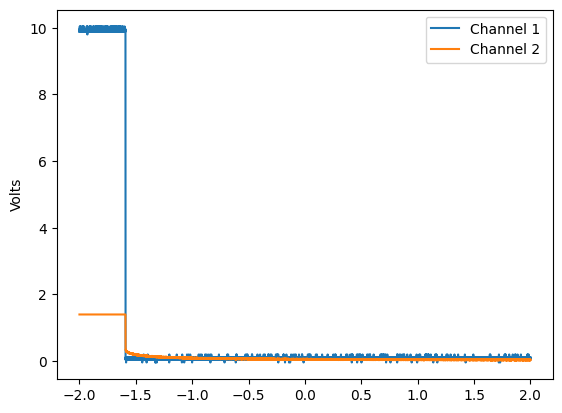

In [5]:
t_raw = data["TIME"]
ch1_raw = data["CH1"]
ch2_raw = data["CH2"]
plt.plot(
    t_raw, 
    ch1_raw,
    label="Channel 1"
)
plt.plot(
    t_raw, 
    ch2_raw,
    label="Channel 2"
)
plt.ylabel("Volts")
plt.legend()


Text(0.5, 0, 'Time (s)')

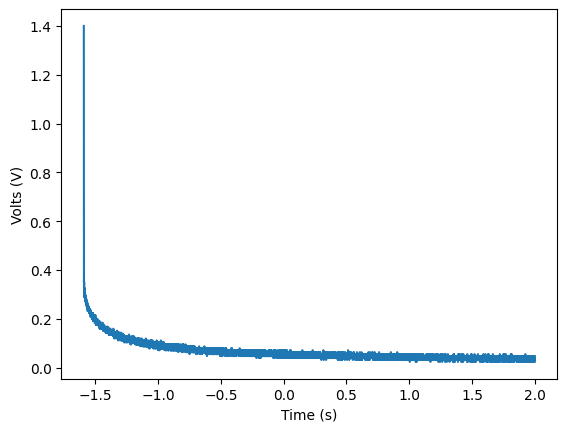

In [6]:
t = t_raw[ch1_raw < 1]
ch2_noisy = ch2_raw[ch1_raw < 1]
plt.plot(t, ch2_noisy)
plt.ylabel("Volts (V)")
plt.xlabel("Time (s)")

In [7]:
from scipy import signal

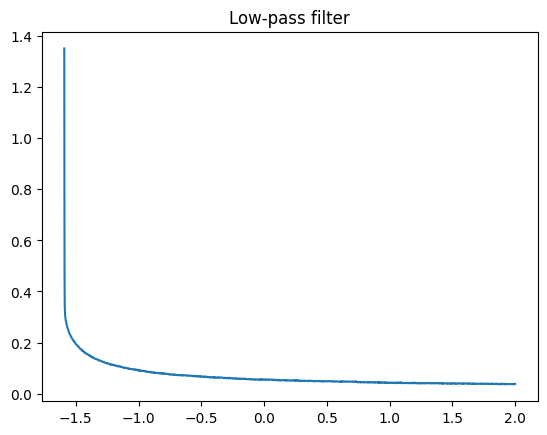

In [8]:
sample_frequency = 2e8
cutoff_frequency = 1e6
b, a = signal.butter(1, 2*cutoff_frequency/sample_frequency)
ch2 = signal.filtfilt(b, a, ch2_noisy)
plt.plot(t, ch2)
plt.title("Low-pass filter")
plt.show()

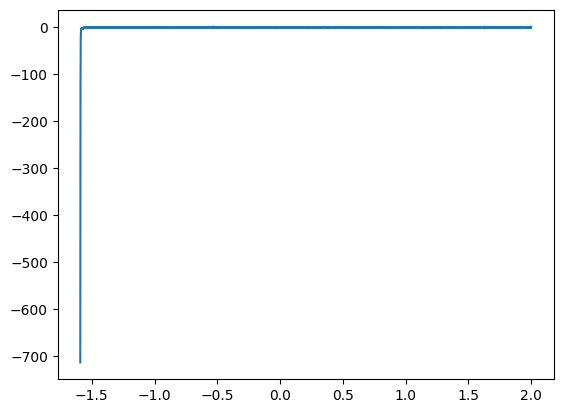

In [9]:
dt = np.array(t)[1] - np.array(t)[0]
dch2dt = np.gradient(ch2, dt)
plt.plot(t, dch2dt)

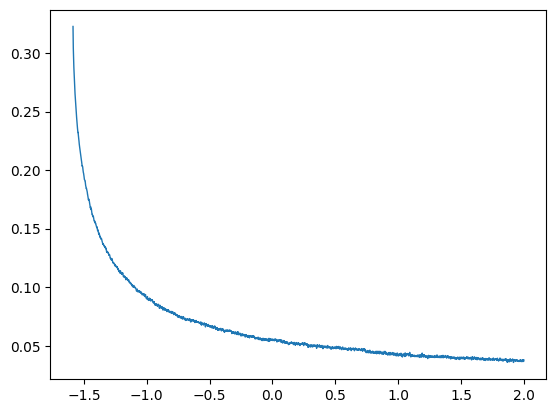

In [10]:
t_truncated = t[dch2dt>-10]
ch2_truncated = ch2[dch2dt>-10]
plt.plot(t_truncated, ch2_truncated,lw=1)

In [11]:
model = lambda t, A, RC, z: A * np.exp(-t/RC) + z
[A_model, RC_model, z_model], cov = sp.optimize.curve_fit(model, t, ch2)
cov

array([[ 6.00259048e-10,  2.11072870e-08, -8.43777837e-10],
       [ 2.11072870e-08,  7.52705712e-07, -2.75460911e-08],
       [-8.43777837e-10, -2.75460911e-08,  4.05962937e-09]])

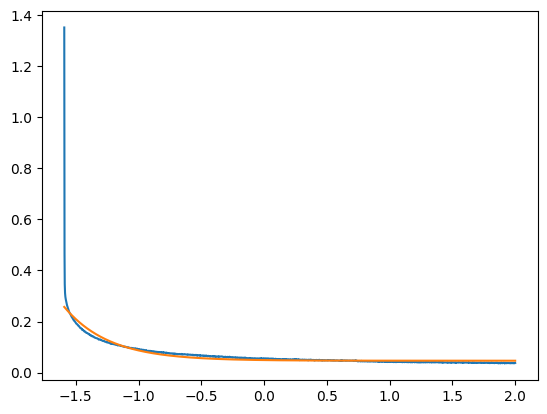

In [12]:
plt.plot(t, ch2)
plt.plot(t, model(t, A_model, RC_model, z_model))

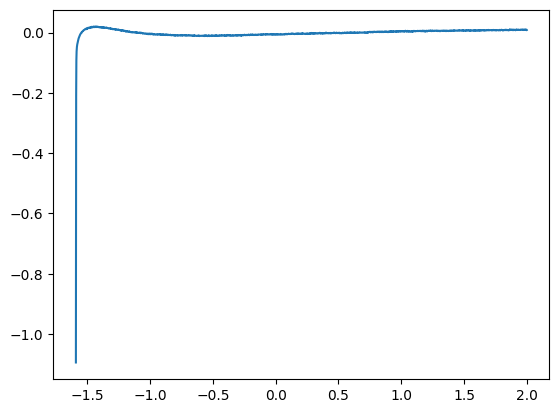

In [13]:
residual = model(t, A_model, RC_model, z_model) - ch2
plt.plot(t, residual)

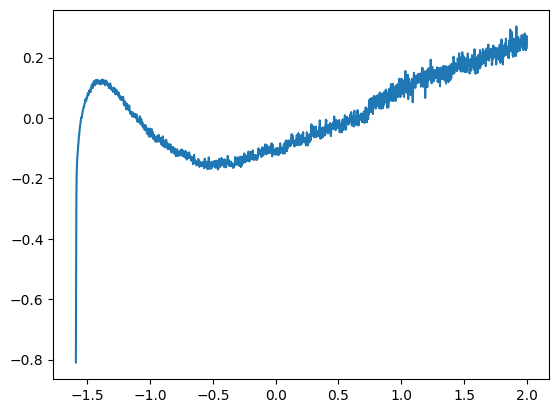

In [14]:
plt.plot(t, residual / ch2)

In [15]:
model_truncated = lambda t_truncated, A, RC, z: A * np.exp(-t_truncated/RC) + z
[A_model_truncated, RC_model_truncated, z_model_truncated], cov_truncated = sp.optimize.curve_fit(model_truncated, t_truncated, ch2_truncated)
cov_truncated

array([[ 2.84168016e-10,  8.09977615e-09, -3.03962331e-10],
       [ 8.09977615e-09,  2.35226405e-07, -8.01653171e-09],
       [-3.03962331e-10, -8.01653171e-09,  9.14413728e-10]])

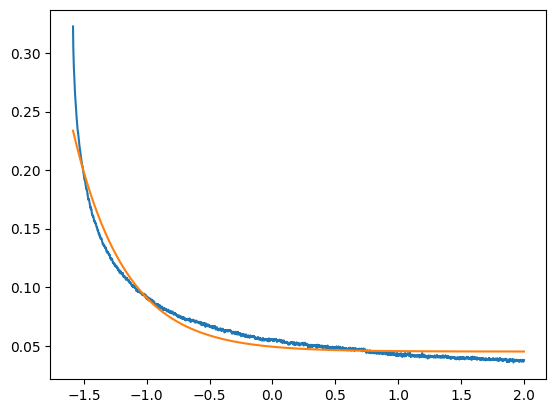

In [16]:
plt.plot(t_truncated, ch2_truncated)
plt.plot(t_truncated, model(t_truncated, A_model_truncated, RC_model_truncated, z_model_truncated))

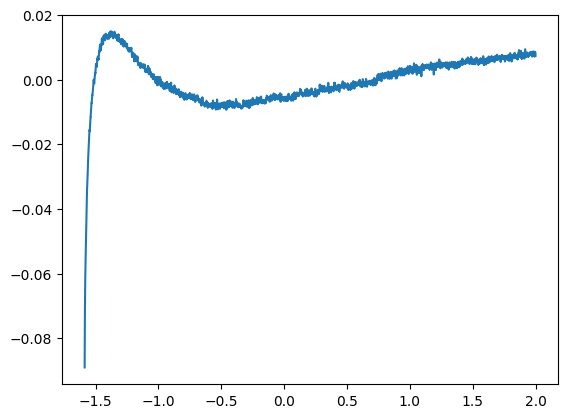

In [17]:
residual_truncated = model_truncated(t_truncated, A_model_truncated, RC_model_truncated, z_model_truncated) - ch2_truncated
plt.plot(t_truncated, residual_truncated)

In [18]:
t_trunc = np.array(t_truncated[residual_truncated == np.max(residual_truncated)])[0]

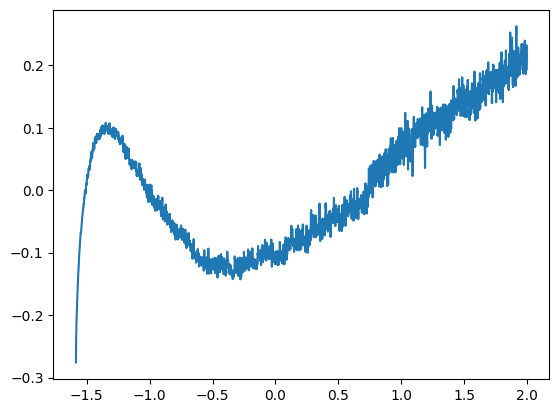

In [19]:
plt.plot(t_truncated, residual_truncated / ch2_truncated)

In [20]:
t_truncated2 = t[t>t_trunc]
ch2_truncated2 = ch2[t>t_trunc]
model_truncated2 = lambda t_truncated2, A, RC, z: A * np.exp(-t_truncated2/RC) + z
[A_model_truncated2, RC_model_truncated2, z_model_truncated2], cov_truncated2 = sp.optimize.curve_fit(model_truncated2, t_truncated2, ch2_truncated2)
cov_truncated2

array([[ 3.06331640e-10,  8.58352290e-09, -2.09828703e-10],
       [ 8.58352290e-09,  2.53360281e-07, -5.51225816e-09],
       [-2.09828703e-10, -5.51225816e-09,  2.04457199e-10]])

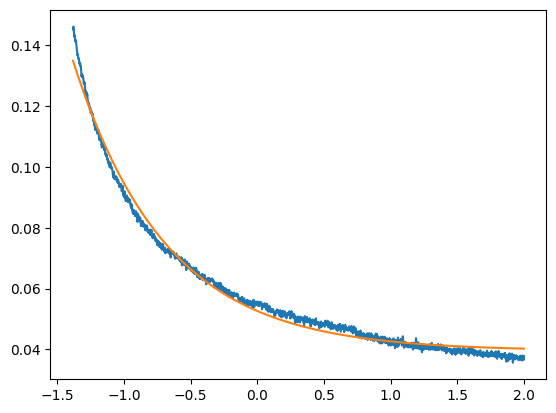

In [21]:
plt.plot(t_truncated2, ch2_truncated2)
plt.plot(t_truncated2, model(t_truncated2, A_model_truncated2, RC_model_truncated2, z_model_truncated2))

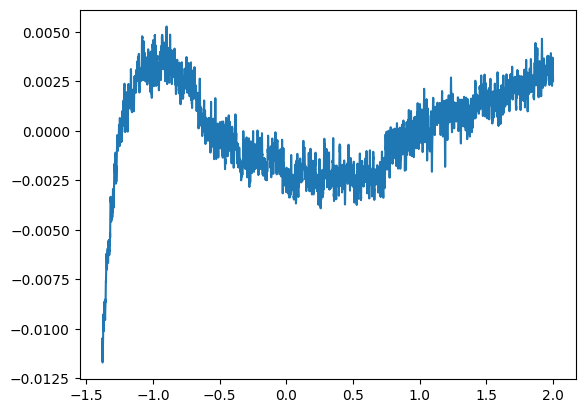

In [22]:
residual_truncated2 = model_truncated2(t_truncated2, A_model_truncated2, RC_model_truncated2, z_model_truncated2) - ch2_truncated2
plt.plot(t_truncated2, residual_truncated2)

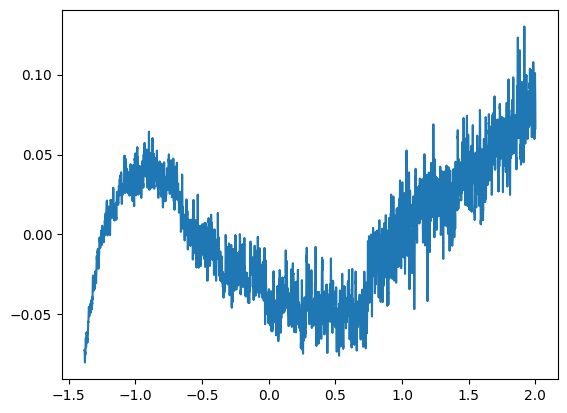

In [23]:
plt.plot(t_truncated2, residual_truncated2 / ch2_truncated2)

In [24]:
v_0 = 10
A_error = np.sqrt(cov[0,0]/t.size)
A_error_truncated = np.sqrt(cov_truncated[0,0]/t_truncated.size)
A_error_truncated2 = np.sqrt(cov_truncated2[0,0]/t_truncated2.size)
B_error = np.sqrt(cov[1,1]/t.size)
B_error_truncated = np.sqrt(cov_truncated[1,1]/t_truncated.size)
B_error_truncated2 = np.sqrt(cov_truncated2[1,1]/t_truncated2.size)
print("A:", A_model / v_0, "+-", A_error / v_0)
print("A-Truncated:", A_model_truncated / v_0, "+-", A_error_truncated / v_0)
print("A-Truncated2:", A_model_truncated2 / v_0, "+-", A_error_truncated2 / v_0)
print("B:", RC_model, "+-", B_error)
print("B-Truncated:", RC_model_truncated, "+-", B_error_truncated)
print("B-Truncated2:", RC_model_truncated2, "+-", B_error_truncated2)

A: 0.0002463427060738001 +- 7.312901511675715e-09
A-Truncated: 0.0004106685673216564 +- 5.03516665892554e-09
A-Truncated2: 0.0013122625024739971 +- 5.383447579355876e-09
B: 0.3577913318011026 +- 2.589601709070289e-06
B-Truncated: 0.4146307492634072 +- 1.4486694014465169e-06
B-Truncated2: 0.6969407755977395 +- 1.5482241102984453e-06
